**Table of Content:**
* PART 1: Load data and initial data preview
* PART 2: EDA (Exploratory Data Analysis)
* PART 3: Visualizing time series data
* PART 4: Financial analysis
* PART 5: Gold risk and volatility profile
* PART 6: Regression analysis - OLS
* PART 7: Gold trading strategy
* PART 8: Backtesting
* PART 9: Predicting gold prices via Facebook Prophet
* PART 10: Communication and alert system/s (we recommend to run the email and Telegram bot code in PyCharm as per the zip file we provided on Moodle. Part 10 code is provided at the end of this colab file for reference only)

Placeholder to load and install libraries:


In [ ]:
import pandas_datareader as pdr
import datetime
import pandas as pd
import fix_yahoo_finance
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import tseries
from pandas.core import tools 
import matplotlib.patches as mpatches
import matplotlib.collections as mcollections
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from fbprophet import Prophet

**PART 1: LOAD DATA and initial data preview**

In [ ]:
# Source: Gather Yahoo Finance data (via the function below) from 2001 to 2020 for Gold, Grude Oil, Silver, S&P 500, and, US Dollar Index

def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return (pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))
tickers = ['GC=F','CL=F', 'SI=F', 'ES=F','DX-Y.NYB']
all_data = get(tickers, datetime.datetime(2001, 11, 1), datetime.datetime(2020, 7, 1))
all_data = all_data.drop(columns="Volume")

In [ ]:
# Data preview - top rows
all_data.head()

High         Low        Open       Close   Adj Close
Ticker Date                                                                  
GC=F   2001-11-01  279.700012  279.700012  279.700012  279.700012  279.700012
       2001-11-02  279.799988  279.799988  279.799988  279.799988  279.799988
       2001-11-05  278.500000  278.500000  278.500000  278.500000  278.500000
       2001-11-06  279.700012  279.700012  279.700012  279.700012  279.700012
       2001-11-07  281.000000  280.500000  280.500000  281.000000  281.000000

In [ ]:
# Data preview - bottom rows
all_data.tail()

High        Low       Open      Close  Adj Close
Ticker   Date                                                             
DX-Y.NYB 2020-06-25  97.599998  97.160004  97.239998  97.430000  97.430000
         2020-06-26  97.680000  97.260002  97.349998  97.500000  97.500000
         2020-06-29  97.650002  97.110001  97.500000  97.540001  97.540001
         2020-06-30  97.800003  97.230003  97.400002  97.389999  97.389999
         2020-07-01  97.620003  97.029999  97.389999  97.199997  97.199997

**PART 2: EDA - Exploratory Data Analysis**

In [ ]:
# Transform dataframe, rename columns and focus oly on "Close" price for the EDA portion

gc = pd.DataFrame(all_data.loc['GC=F']['Close'])
gc = gc.rename(columns={"Close":"Gold"})
sc = pd.DataFrame(all_data.loc['SI=F']['Close'])
sc = sc.rename(columns={"Close":"Silver"})
spc = pd.DataFrame(all_data.loc['ES=F']['Close'])
spc = spc.rename(columns={"Close":"S&P500"})
oc = pd.DataFrame(all_data.loc['CL=F']['Close'])
oc = oc.rename(columns={"Close":"Oil"})
uic = pd.DataFrame(all_data.loc['DX-Y.NYB']['Close'])
uic = uic.rename(columns={"Close":"US Index"})
result = pd.concat([gc, sc,spc,oc, uic], axis=1)
# Data preview - top rows
result.head()

Gold  Silver   S&P500        Oil    US Index
Date                                                          
2001-11-01  279.700012   4.196  1082.00  20.389999  114.459999
2001-11-02  279.799988   4.099  1089.50  20.180000  114.540001
2001-11-05  278.500000   4.087  1103.75  20.020000  114.540001
2001-11-06  279.700012   4.108  1121.00  19.920000  114.809998
2001-11-07  281.000000   4.118  1119.00  20.090000  114.980003

In [ ]:
# Describe the dataset: mean, min, max, IQR among others
result.describe()

Gold       Silver       S&P500          Oil     US Index
count  4728.000000  4732.000000  4741.000000  4674.000000  4687.000000
mean   1026.413261    15.989062  1647.822571    64.307441    88.852195
std     442.095322     8.117746   653.590428    25.424797     9.881474
min     272.200012     4.026000   676.000000   -37.630001    71.330002
25%     619.399994    11.029250  1145.000000    46.032499    80.704998
50%    1186.850037    15.863000  1383.500000    60.725000    87.599998
75%    1322.724976    18.362000  2079.750000    85.432503    96.274998
max    1888.699951    48.584000  3388.250000   145.179993   120.239998

In [ ]:
# Review the dataframe and we can see there are some missing values 
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4777 entries, 2001-11-01 to 2020-07-01
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gold      4728 non-null   float64
 1   Silver    4732 non-null   float64
 2   S&P500    4741 non-null   float64
 3   Oil       4674 non-null   float64
 4   US Index  4687 non-null   float64
dtypes: float64(5)
memory usage: 223.9 KB


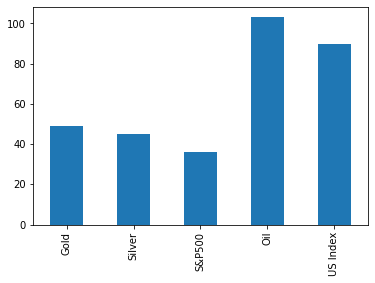

In [ ]:
# Lets plot the NaN value and see more cleraly what we have
result.isnull().sum().plot.bar()

# Its mostly Oil and US index that have NaN values

In [ ]:
# First we wantted to replace NaN with average per columns but that didnt work well with time series
# result1=result.fillna(result.mean())
# Therefore, we decided to propagate non-null values forward
result1=result.fillna(method='ffill')

In [ ]:
# Lets check NaN values again
result1.isnull().isnull().sum()

# We dont have any NaNs - problem solved!

Gold        0
Silver      0
S&P500      0
Oil         0
US Index    0
dtype: int64

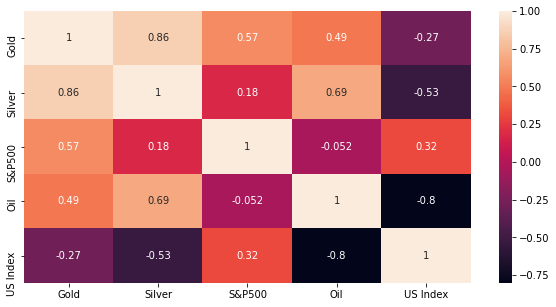

In [ ]:
# What is correlated to Gold via Correlation and HeatMap analysis

corr = result1.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True)
corr.style.background_gradient(cmap = "coolwarm").set_precision(2)

# Silver is mostly correlated to Gold, while US Index has an inverse relatioship

In [ ]:
# Interactive GOLD Chart with date range slider
# The chart below is interactive and can use your mouse to go over it and utlize the slider to "slice" the time interval

# Reset index on original dataframe  to include "date" as a column and part of DF so we can chart dates on the "x" asis
new_df=result1.copy()
new_df1=new_df.reset_index()
new_df1.columns=["Date","Gold","Silver","S&P500","Oil","US Index"]

# Interactive Chart with date slider at the bottom
df = new_df1
fig = px.line(df,x="Date", y='Gold', title='GOLD Time Series with Date range slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
# Interactive GOLD Chart with date range slider and Time Selectors
# The chart below is interactive and you can use your mouse to go over it and utlize the slider to "slice" the time interval and/or click the m,6m,YTD,1Y, or all fast buttons on the top left corner

fig = px.line(df, x='Date', y='Gold', title='GOLD: Time Series with Date Range Slider and Time Selectors')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

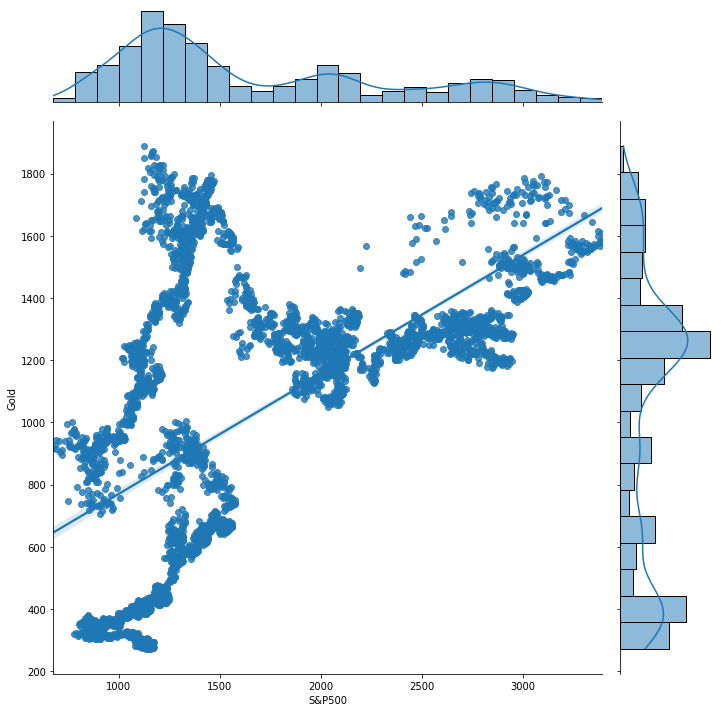

In [ ]:
# Regplot with marginal distplot to explore Gold and S&P500 at first glance
# The histograms tells us the distribution , while, the line and confidence interval depicts the fit between the variables

sns.jointplot(x="S&P500", y="Gold", data=result1 , height = 10 , kind="reg")

**PART 3: Visualizing Time Series Data**

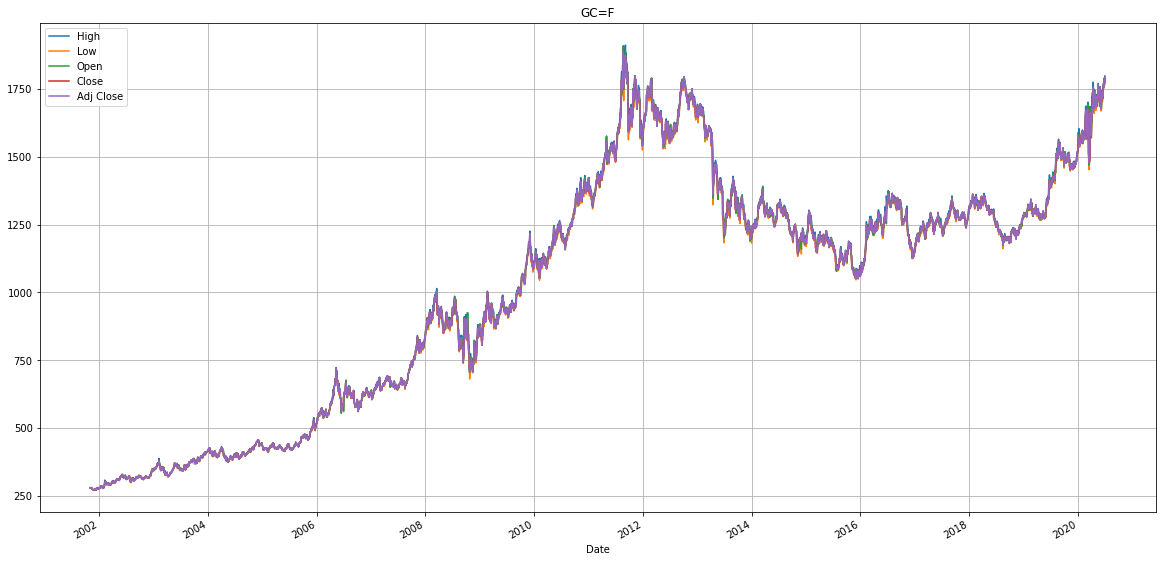

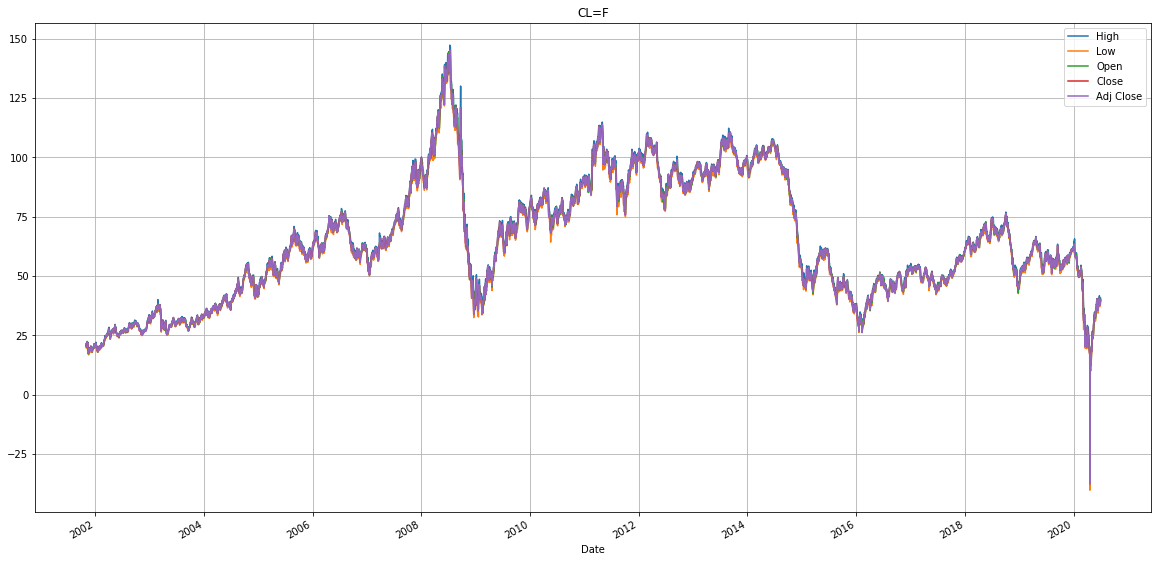

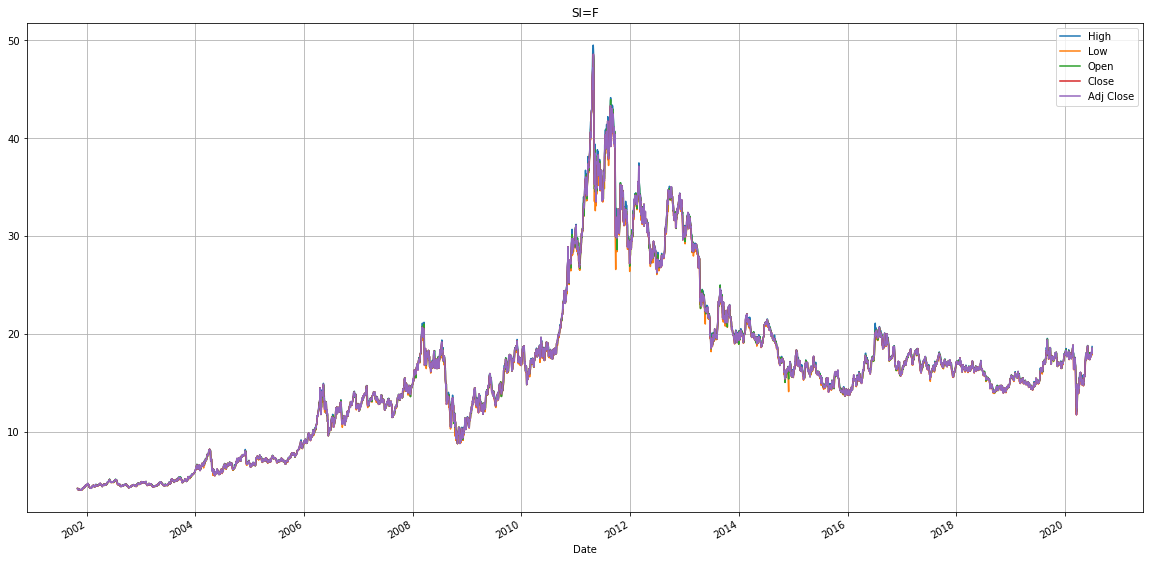

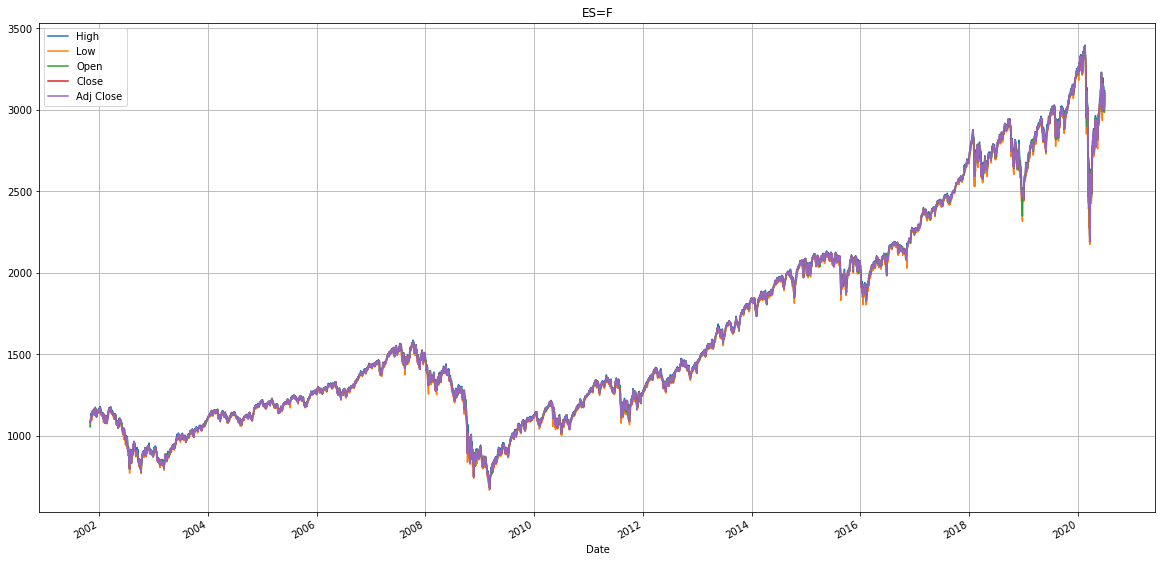

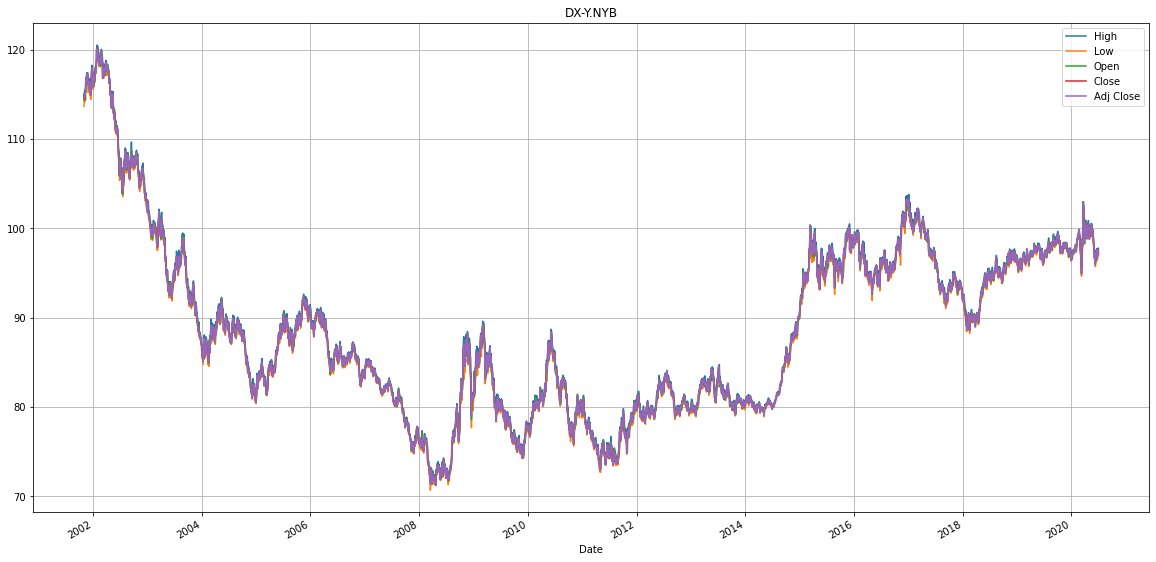

In [ ]:
# Lets take a look at each of our variables

def time_plot_show(data):
  for i in tickers:
    p = data.loc[i].plot.line(grid=True,figsize = (20,10))
    p.set_title(i)

# Show the plot
plt.show()
time_plot_show(all_data)


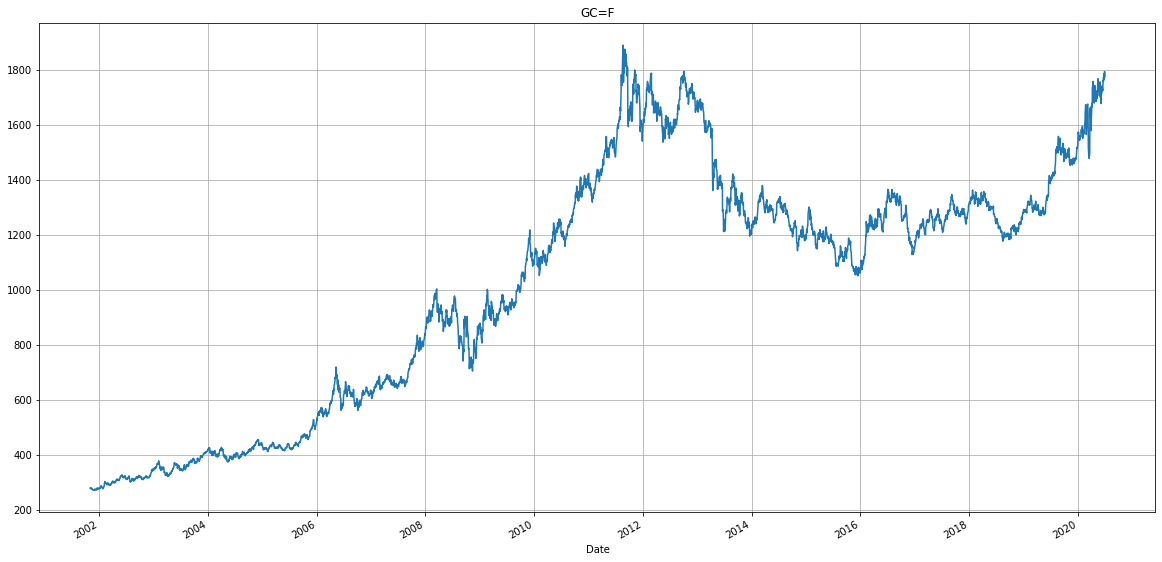

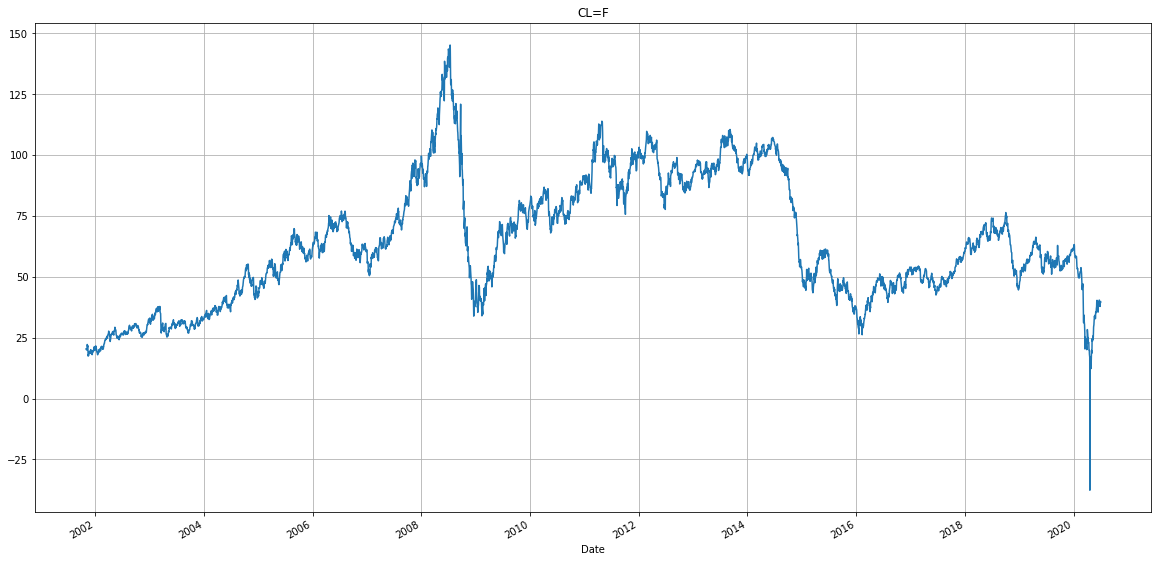

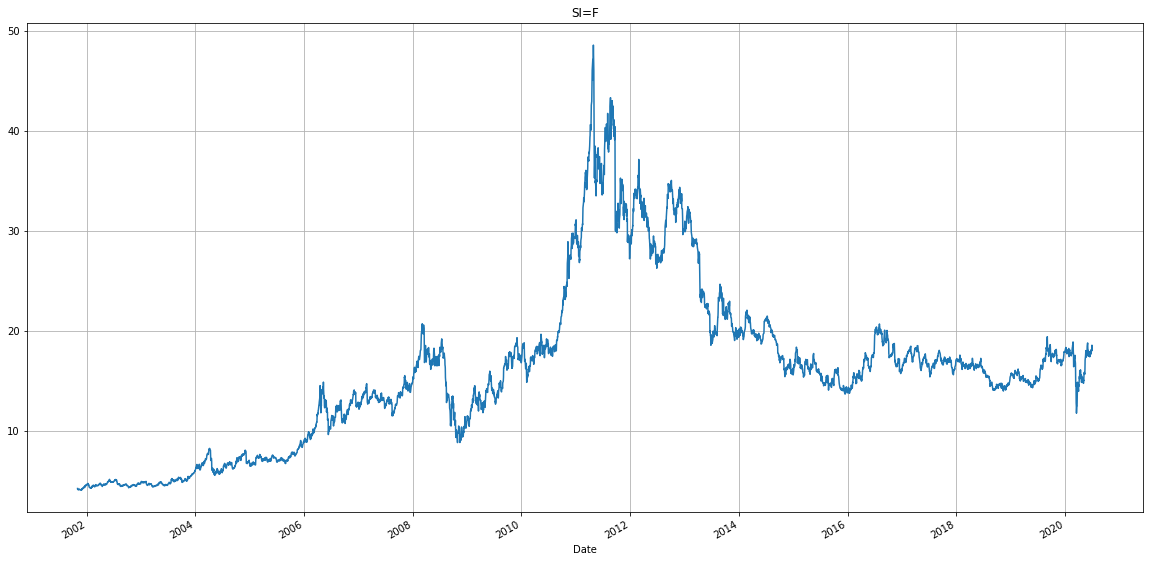

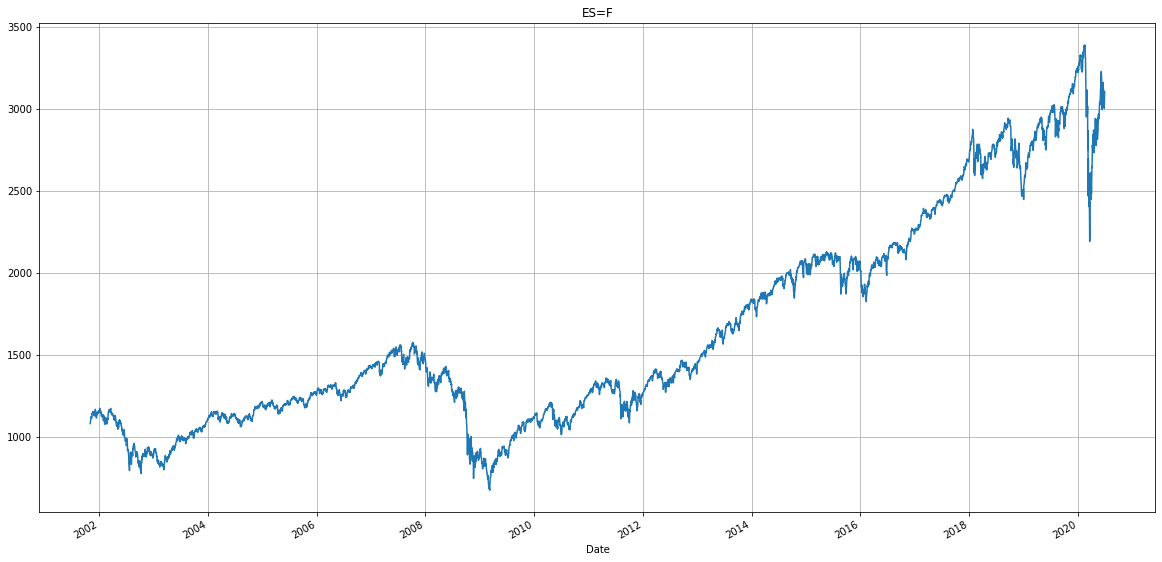

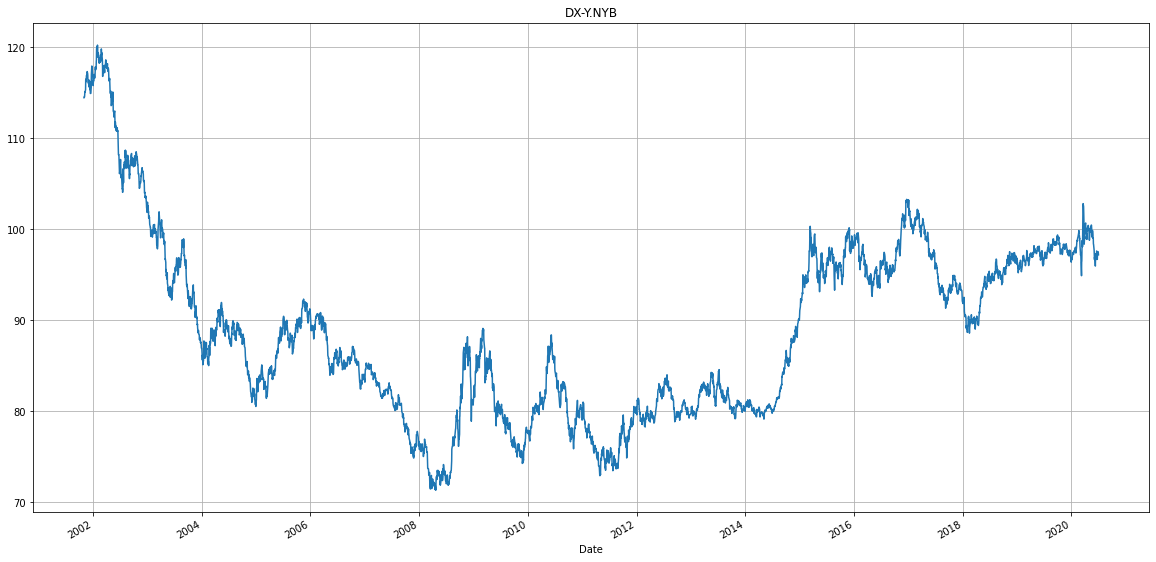

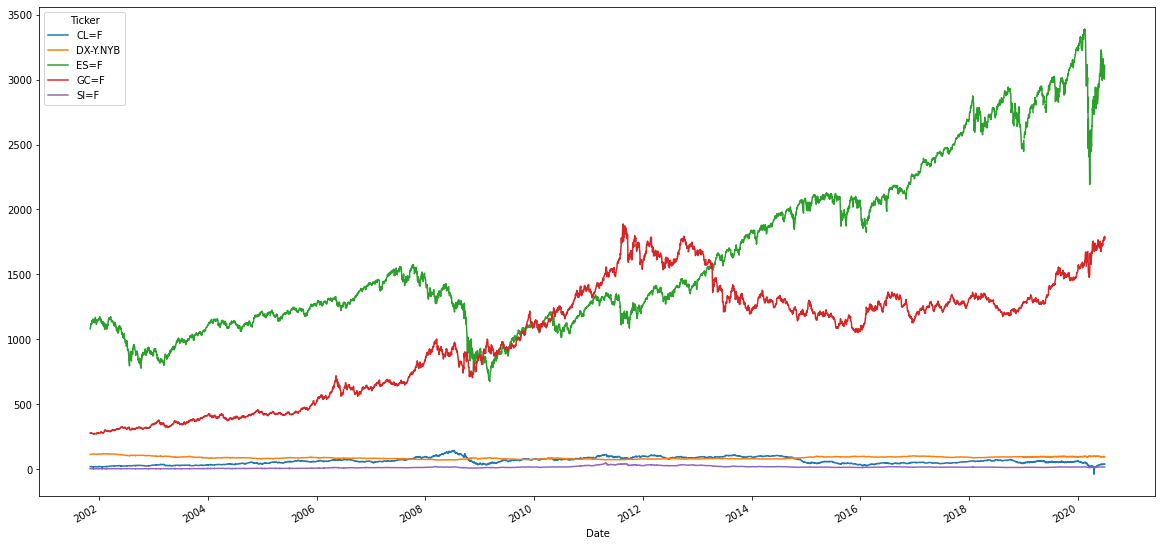

In [ ]:
# Lets take a look at the closing prices

# Plot the closing prices
def time_plot_show(data):
  for i in tickers:
    p = data.loc[i]['Close'].plot(grid=True, figsize = (20,10))
    p.set_title(i)

# Show the plot
    plt.show()
time_plot_show(all_data)
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
daily_close_px.plot(sharex=True, figsize = (20,10))
plt.show()



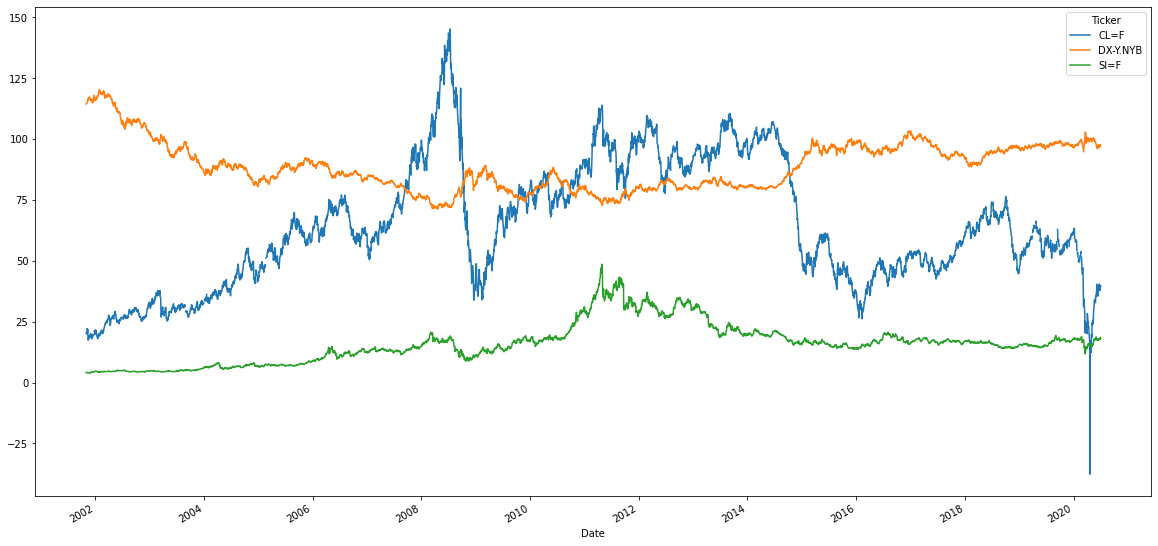

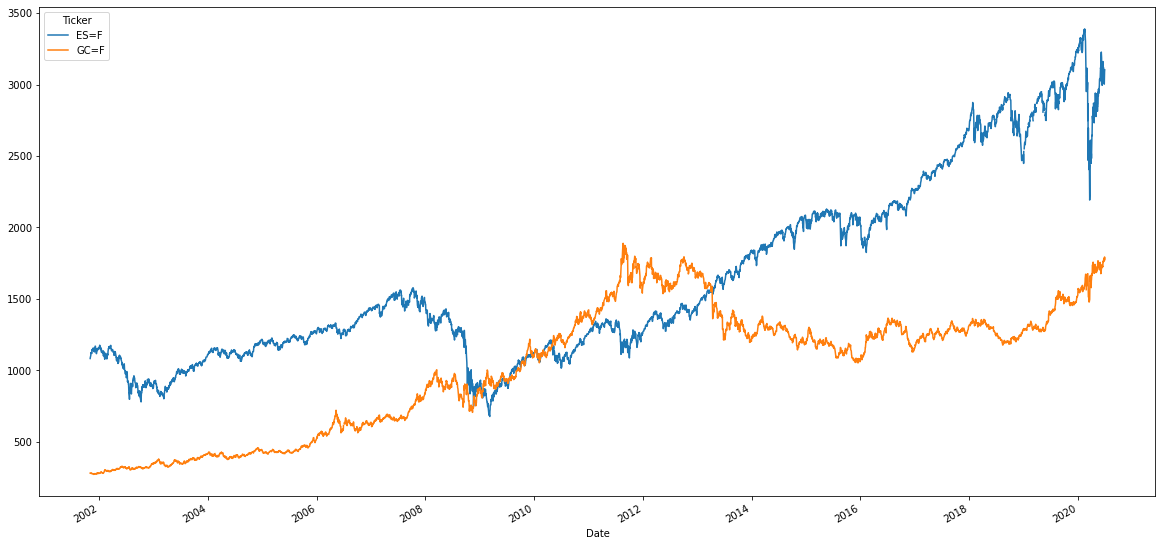

In [ ]:
# Ticker Combination charting and analysis

tickers1 = ['CL=F', 'SI=F', 'DX-Y.NYB']
data1 = get(tickers1, datetime.datetime(2001, 11, 1), datetime.datetime(2020, 7, 1))
tickers2 = ['GC=F', 'ES=F']
data2 = get(tickers2, datetime.datetime(2001, 11, 1), datetime.datetime(2020, 7, 1))

ax1 = data1[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
ax1.plot(figsize = (20,10))
ax2 = data2[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
ax2.plot(figsize = (20,10))
plt.show()

**PART 4: Financial Analysis**

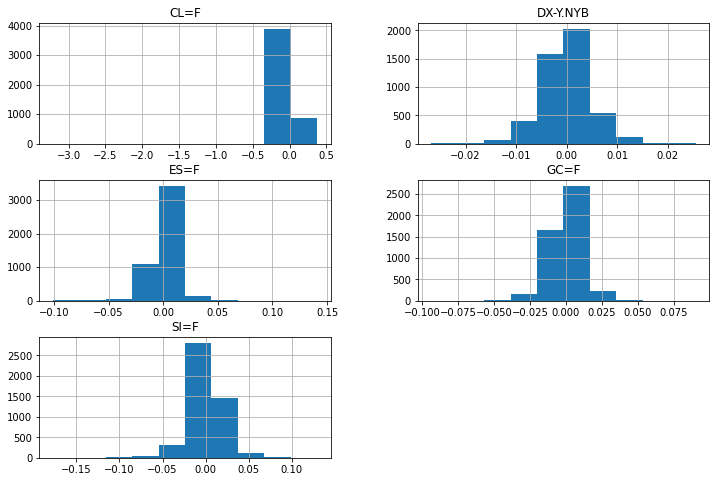

Ticker         CL=F     DX-Y.NYB         ES=F         GC=F         SI=F
count   4777.000000  4777.000000  4777.000000  4777.000000  4777.000000
mean      -0.000344    -0.000022     0.000297     0.000449     0.000501
std        0.056536     0.004899     0.012358     0.011152     0.019609
min       -3.214832    -0.026803    -0.101100    -0.093538    -0.177541
25%       -0.012081    -0.002771    -0.004172    -0.004742    -0.007940
50%        0.000294     0.000000     0.000678     0.000438     0.001036
75%        0.012533     0.002676     0.005450     0.006289     0.010171
max        0.376623     0.025558     0.141134     0.090277     0.129707


In [ ]:
# Financial Analysis - daily % change

# Calculate daily percentage change
daily_pct_change = daily_close_px.pct_change()

# Replace NA values with zero/s
daily_pct_change.fillna(0, inplace=True)

# Plot distribution via histogram/s
daily_pct_change.hist(figsize=(12,8))
plt.show()

# Pull up summary stats in a table format
print(daily_pct_change.describe())

# Gold: The distribution looks very symmetrical and normally distributed: the daily changes center around the bin with 0 (zero) value

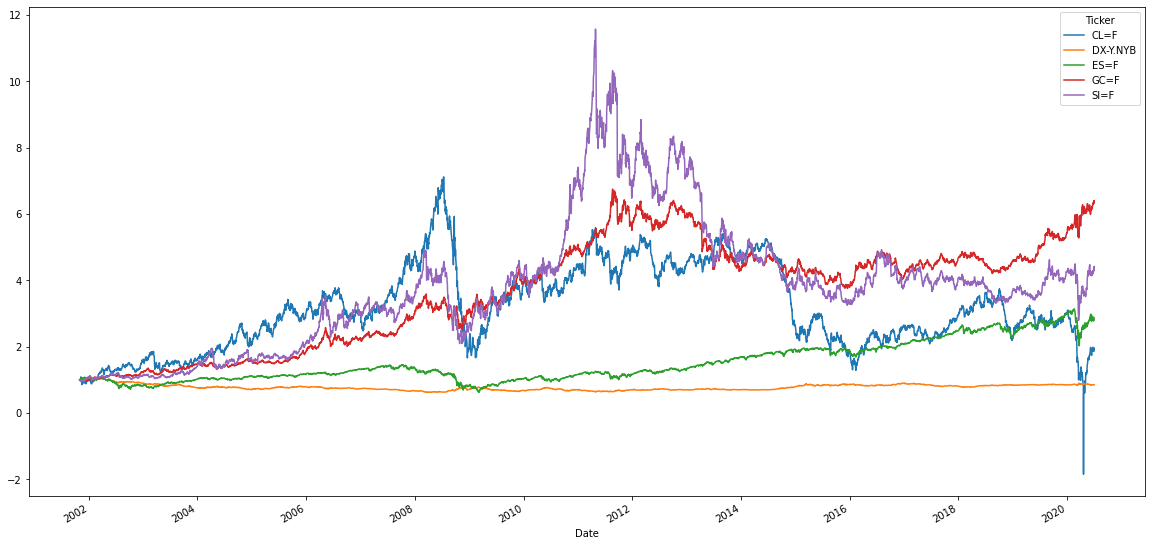

In [ ]:
# Financial Analysis - Daily Cummulative returns
# The cumulative daily rate of return is useful to determine the value of an investment at regular intervals

# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_change).cumprod()

# Plot cumulative daily returns
cum_daily_return.plot(figsize = (20,10))
plt.show()

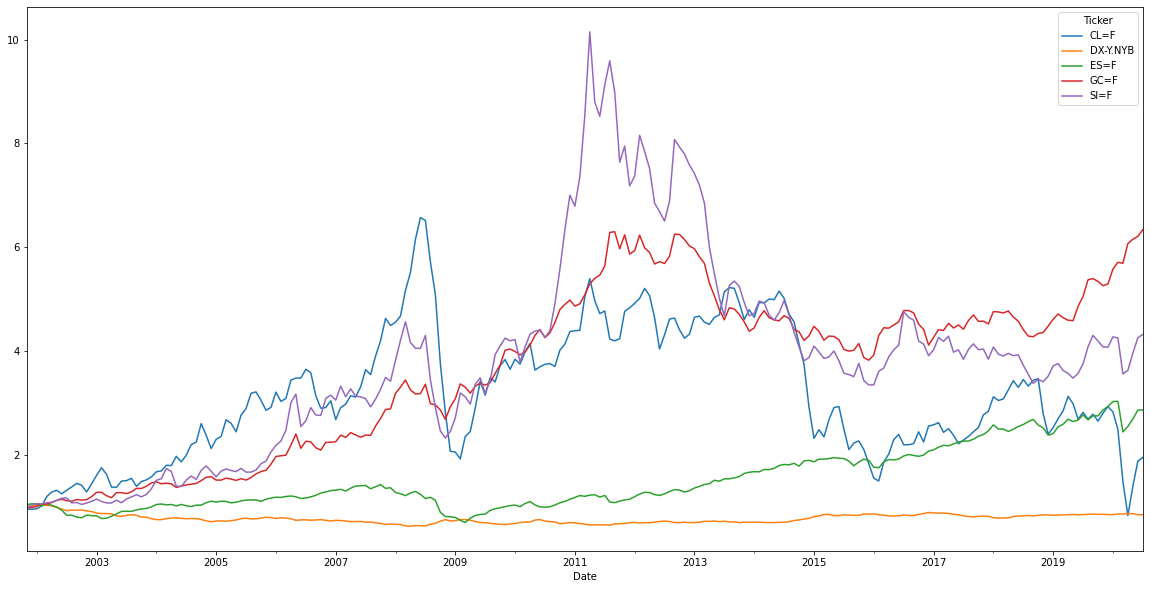

In [ ]:
# Financial Analysis - Monthly Cummulative Returns

# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Plot cumulative daily returns
cum_monthly_return.plot(figsize = (20,10))
plt.show()

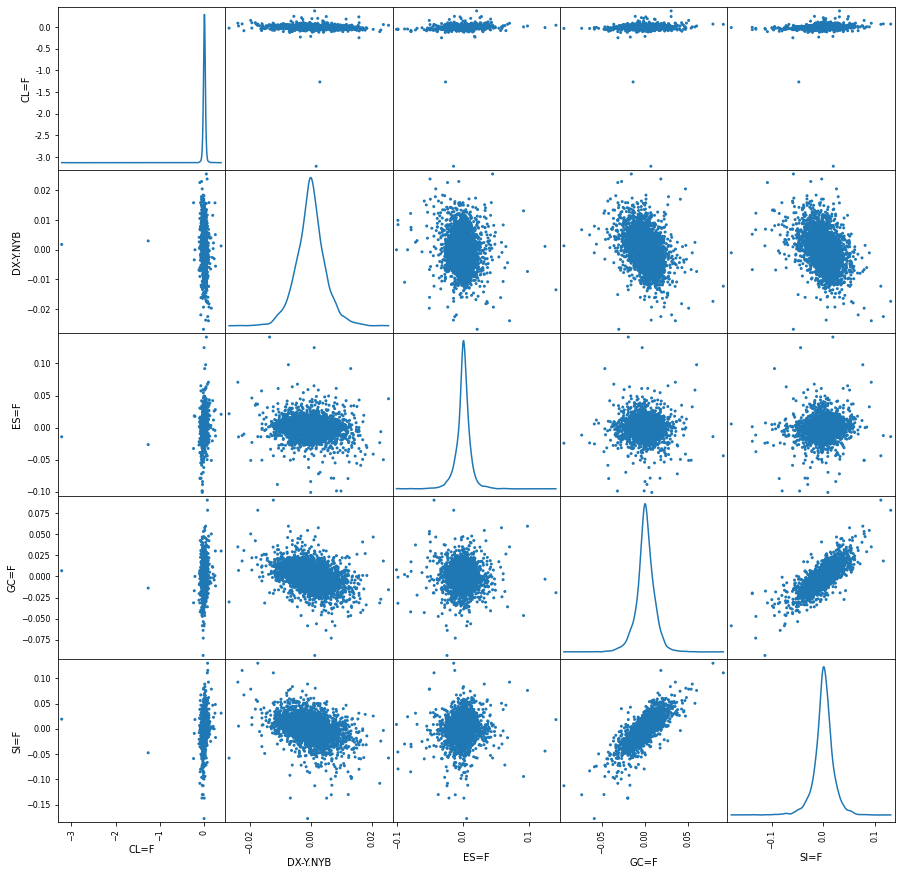

In [ ]:
# Plot a scatter matrix with the daily_pct_change data 
# This shows us the return relationship and distribution of the assigned variables

pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=1,figsize=(15,15))
plt.show()

PART 5: Gold Risk / Volatility Profile

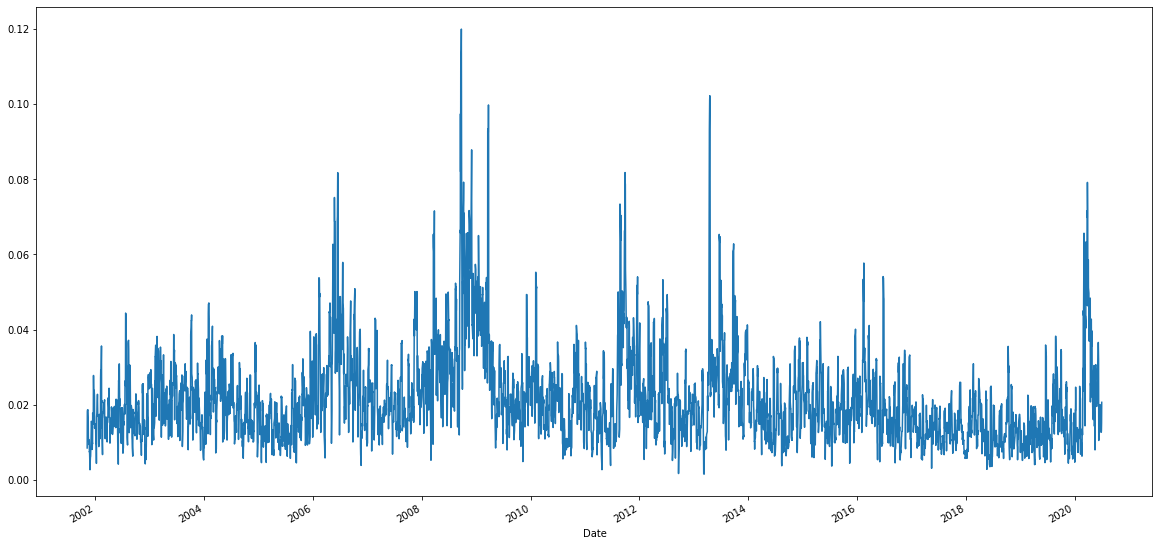

In [ ]:
# Volatility Calculation (GOLD)

# Measure change in variance in the returns over a specific period of time
# The volatility is calculated by taking a rolling window standard deviation on the % change
# Gold violitility has been very significant in 2020, esp. around Covid-19 timeline as per chart below (also we can see the past financial crisis spikes)

# Define the minumum of periods
min_periods = 5

# Volatility calc
vol = daily_pct_change['GC=F'].rolling(min_periods).std() * np.sqrt(min_periods) 

# Volatility plot
vol.plot(figsize=(20, 10))
plt.show()

PART 6: Regression Analysis - OLS

In [ ]:
# Regression Analysis - OLS via statsmodels library

# Pull only adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# Pull Gold returns 
gold_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'GC=F']
gold_returns.index = gold_returns.index.droplevel('Ticker')

# Pull Silver returns
silv_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'SI=F']
silv_returns.index = silv_returns.index.droplevel('Ticker')

# Pull S&P500 returns
es_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'ES=F']
es_returns.index = es_returns.index.droplevel('Ticker')

# Pull Oil returns
cl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'CL=F']
cl_returns.index = cl_returns.index.droplevel('Ticker')

# Pull USD Index returns
ui_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'DX-Y.NYB']
ui_returns.index = ui_returns.index.droplevel('Ticker')

# Build new DataFrame with all 5 returns and remove any NaN values
return_data = pd.concat([gold_returns, silv_returns, es_returns, cl_returns, ui_returns], axis=1)[1:]
return_data.columns = ['GC=F', 'SI=F','ES=F','CL=F','DX-Y.NYB']

# Add a constant 
X = np.column_stack((return_data['SI=F'], return_data['ES=F'],return_data['CL=F'],return_data['DX-Y.NYB']))
X = sm.add_constant(X)

# Regression model construction
model = sm.OLS(return_data['GC=F'],X, missing='drop').fit()

# Lets see it
print(model.summary(xname=["Const","Silver","S&P500","Oil","USD Index"]))

                            OLS Regression Results                            
Dep. Variable:                   GC=F   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     2113.
Date:                Sat, 05 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:43:19   Log-Likelihood:                 16658.
No. Observations:                4648   AIC:                        -3.331e+04
Df Residuals:                    4643   BIC:                        -3.327e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.0002   9.86e-05      2.508      0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in log



In [ ]:
# We build a new model here, while, deleting insignificant variables

# Add a constant 
X1 = np.column_stack((return_data['SI=F'], return_data['DX-Y.NYB']))
X1 = sm.add_constant(X1)

# Regression model construction
model1 = sm.OLS(return_data['GC=F'],X1, missing='drop').fit()

# Lets see it
print(model1.summary(xname=["Const","Silver","USD Index"]))

                            OLS Regression Results                            
Dep. Variable:                   GC=F   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     4018.
Date:                Sat, 05 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:43:23   Log-Likelihood:                 16592.
No. Observations:                4651   AIC:                        -3.318e+04
Df Residuals:                    4648   BIC:                        -3.316e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.0002      0.000      2.220      0.0

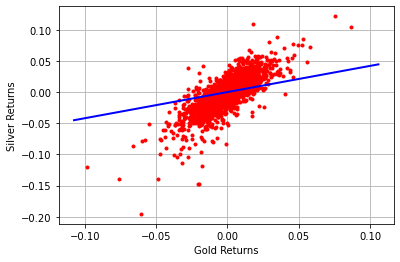

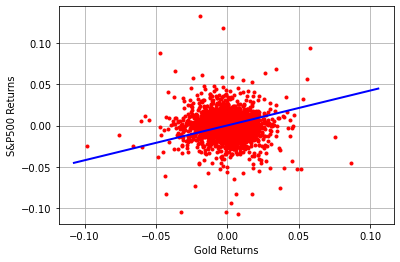

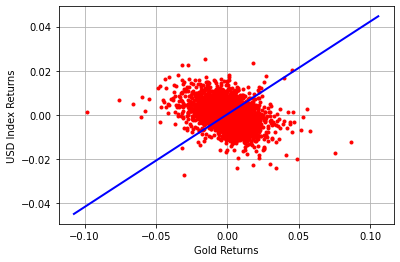

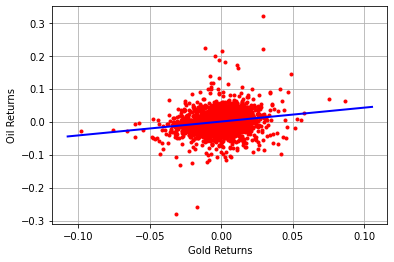

In [ ]:
# Show the return plot one by one, vs gold

def return_plot(data_dict):
  for i in data_dict:
    #plt.figure(figsize = (10,10))
    # Plot returns of gold and silver
    plt.plot( return_data['GC=F'], return_data[i], 'r.')

# Add an axis to the plot
    ax = plt.axis() 

# Initialize `x`
    x = np.linspace(ax[0], ax[1] + 0.01)

# Plot the regression line
    plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

# Customize the plot
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel('Gold Returns')
    plt.ylabel(data_dict[i]+" Returns")

# Show the plot
    plt.show()

data_dict = {"SI=F":"Silver", "ES=F":"S&P500", "DX-Y.NYB":"USD Index", "CL=F":"Oil"}
return_plot(data_dict)

In [ ]:
# Interactive OLS Regression Chart for Gold and Silver
# You can place your mouse over the chart below and can see the regression formula, R^2, and x and y values

df = new_df1
fig = px.scatter(
    df, x='Silver', y='Gold', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)

fig.show()

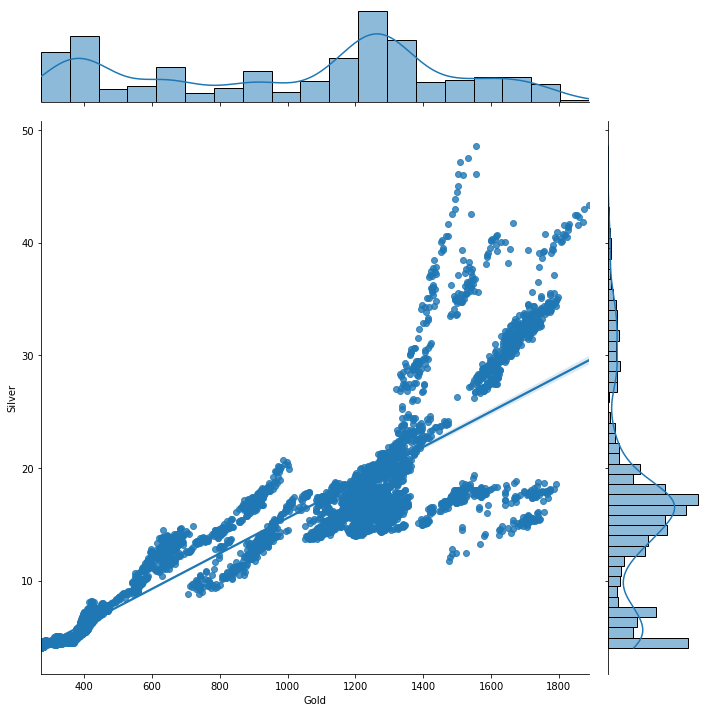

In [ ]:
# Regplot with marginal distplot - Silver vs Gold
# The histograms tells us the distribution , while, the line and confidence interval depicts the fit between the variables

sns.jointplot(x="Gold", y="Silver", data=result1 , height = 10 , kind="reg")

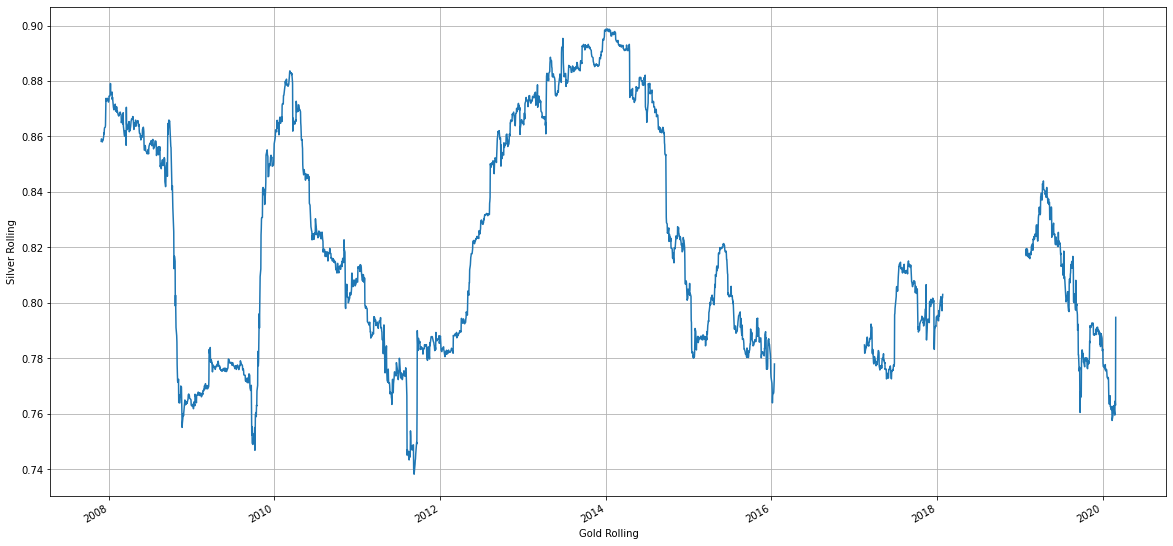

In [ ]:
# Plot the rolling correlation return of Gold and Silver

return_data['SI=F'].rolling(window=252).corr(return_data['GC=F']).plot(figsize=(20,10))
plt.grid(True)
plt.axis('tight')
plt.xlabel('Gold Rolling')
plt.ylabel("Silver Rolling")
plt.show()

**PART 7: GOLD TRADING STRATEGY**

In [ ]:
# Gold Trading Strategy: The moving average crossover

# Create two separate Simple Moving Averages with 2 windows: 40 days and 100 days
# If short moving average exceeds the long moving average - "BUY SIGNAL"
# If long moving average exceeds the short moving average  - "SELL SIGNAL"

# Short and long windows
short_window = 40
long_window = 100

# Create an empty signals DataFrame with 'signal' column
signals = pd.DataFrame(index=all_data.loc['GC=F'].index)
signals['signal'] = 0.0

# Create a short simple moving average
signals['short_mavg'] = all_data.loc['GC=F']['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create a long simple moving average
signals['long_mavg'] = all_data.loc['GC=F']['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create the signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate the trading orders and lets look at our signals closer
signals['positions'] = signals['signal'].diff()
print(signals)

            signal   short_mavg    long_mavg  positions
Date                                                   
2001-11-01     0.0   279.700012   279.700012        NaN
2001-11-02     0.0   279.750000   279.750000        0.0
2001-11-05     0.0   279.333333   279.333333        0.0
2001-11-06     0.0   279.425003   279.425003        0.0
2001-11-07     0.0   279.740002   279.740002        0.0
...            ...          ...          ...        ...
2020-06-26     1.0  1730.345004  1683.463000        0.0
2020-06-28     1.0  1732.595004  1684.847001        0.0
2020-06-29     1.0  1734.355005  1686.195001        0.0
2020-06-30     1.0  1736.332504  1687.725001        0.0
2020-07-01     1.0  1737.210004  1689.816001        0.0

[4728 rows x 4 columns]


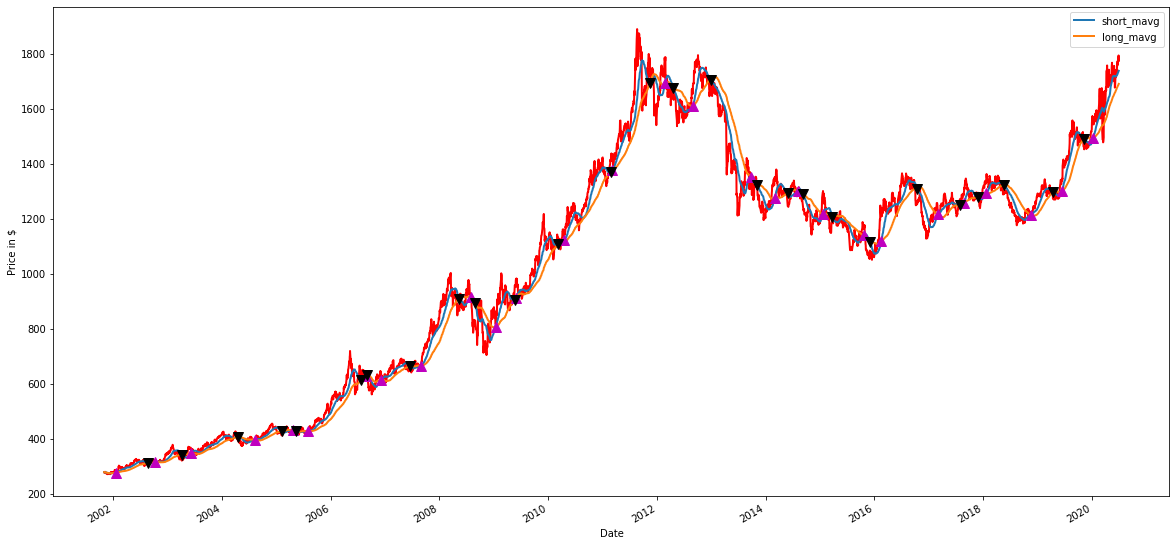

In [ ]:
# Visualize our Gold Trading Strategy

# Set the plot figure
fig = plt.figure(figsize=(20,10))

# Add a subplot
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot closing price
all_data.loc['GC=F']['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot short/long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')

plt.show()

# Trading explanation:
# The pink triangle means "BUY GOLD" as we think gold price will increase in the future
# The black triangle facing down means "SELL GOLD" as we think gold price will decrease in the future


**PART 8: Backtesting**

In [ ]:
# Backtesting The Trading Strategy via a simple method and calculate its final performance

# Assign initial capital of $100,000
initial_capital= float(100000.0)

# Create DataFrame
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy 100 shares
positions['GC=F'] = 100*signals['signal']   
  
# Set portfolio   
portfolio = positions.multiply(all_data.loc['GC=F']['Adj Close'], axis=0)

# Store the difference in positions
pos_diff = positions.diff()

# Add holdings to portfolio (this stores what we buy)
portfolio['holdings'] = (positions.multiply(all_data.loc['GC=F']['Adj Close'], axis=0)).sum(axis=1)

# Add cash to portfolio (this stores residual cash we have on hand)
portfolio['cash'] = initial_capital - (pos_diff.multiply(all_data.loc['GC=F']['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add total to portfolio (its a sum of holdings and our residual cash together)
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add returns to portfolio (this is where we store our returns here)
portfolio['returns'] = portfolio['total'].pct_change()

# Print a sample of the last few rows of our portfolio simulation
portfolio.tail()

GC=F       holdings          cash          total   returns
Date                                                                           
2020-06-26  177250.000000  177250.000000  39280.010986  216530.010986  0.004826
2020-06-28  178530.004883  178530.004883  39280.010986  217810.015869  0.005911
2020-06-29  177480.004883  177480.004883  39280.010986  216760.015869 -0.004821
2020-06-30  179300.000000  179300.000000  39280.010986  218580.010986  0.008396
2020-07-01  177319.995117  177319.995117  39280.010986  216600.006104 -0.009058

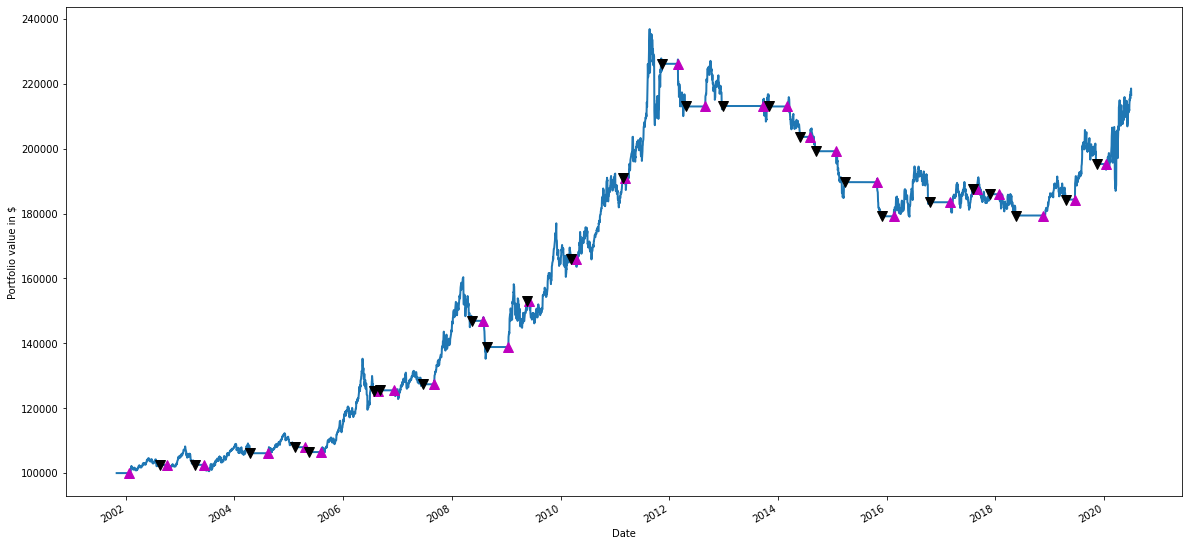

In [ ]:
# Lets have a look at our portfolio value visualy over the years

# Create figure
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in $
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

plt.show()

In [ ]:
# Lets evaluate !

# Pull the returns of our strategy
returns = portfolio['returns']

# Calculate anualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Lets see the Sharpe ratio
print(sharpe_ratio)

0.5205381084193488


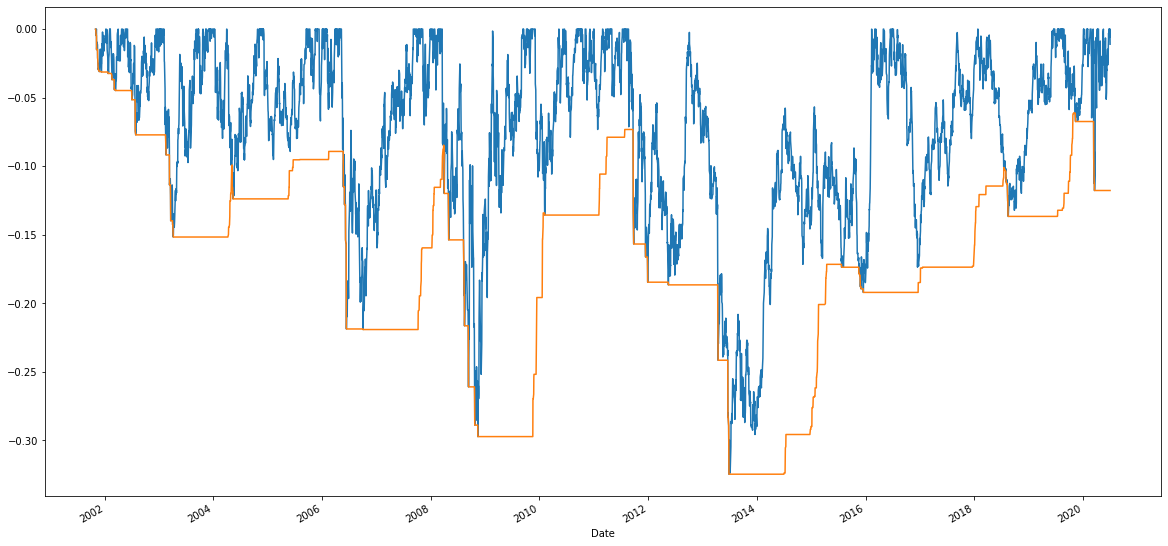

In [ ]:
# Calculate Maximum Drawdown
# Measures the largest single drop from peak to bottom in the value of our portfolio

# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = all_data.loc['GC=F']['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = all_data.loc['GC=F']['Adj Close']/rolling_max - 1.0

# Calculate the minimum (this is negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Lets see
fig = plt.figure(figsize=(20,10))
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show()

In [ ]:
# Lastly lets calculate the Compound Annual Growth Rate (CAGR)
# What is CAGR (?)
# It will tell us what we have at the end of our investment period

# Get Number of days
days = (all_data.loc['GC=F'].index[-1] - all_data.loc['GC=F'].index[0]).days

# Calculate CAGR 
cagr = ((((all_data.loc['GC=F']['Adj Close'][-1]) / all_data.loc['GC=F']['Adj Close'][1])) ** (365.0/days)) - 1

# Lets see CAGR rate
print(cagr)

# Our annual aggregate return is 10% !!!
# This means our gold trading strategy works as verified by our backtesting method !

0.10391684055955341


**PART 9: Predicting Gold prices via Facebook Prophet**

In [ ]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet
import statsmodels.api as sm
from scipy import stats
from plotly import tools
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import urllib.request
from google.colab import files as google_files
import itertools
# Remove warning messages
import warnings
warnings.filterwarnings("ignore")
# plt.style.available
plt.style.use("seaborn-whitegrid")

In [ ]:
# Get historical gold price data

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['GC=F']
gold_data = get(tickers, datetime.datetime(2001, 11, 1), datetime.datetime(2020, 7, 1))
# Copy the dataframe
df_prophet=gold_data
# Reset index
df_prophet=df_prophet.reset_index()
# Replace the column name to ticks
df_prophet = df_prophet.rename(columns={'Ticker': 'Ticks'})
# Lets use friendly name for gold prediction
gold = df_prophet.loc[df_prophet['Ticks'] == 'GC=F']
gold.head()

Ticks       Date        High  ...       Close  Volume   Adj Close
0  GC=F 2001-11-01  279.700012  ...  279.700012     0.0  279.700012
1  GC=F 2001-11-02  279.799988  ...  279.799988     0.0  279.799988
2  GC=F 2001-11-05  278.500000  ...  278.500000     0.0  278.500000
3  GC=F 2001-11-06  279.700012  ...  279.700012    90.0  279.700012
4  GC=F 2001-11-07  281.000000  ...  281.000000     5.0  281.000000

[5 rows x 8 columns]

In [ ]:
# Lets have a glance over the data
gold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4728 entries, 0 to 4727
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticks      4728 non-null   object        
 1   Date       4728 non-null   datetime64[ns]
 2   High       4728 non-null   float64       
 3   Low        4728 non-null   float64       
 4   Open       4728 non-null   float64       
 5   Close      4728 non-null   float64       
 6   Volume     4728 non-null   float64       
 7   Adj Close  4728 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 332.4+ KB


In [ ]:
# Create a copy to avoid the SettingWarning .loc issue 
gold_df = gold.copy()
# Change to datetime datatype
gold_df.loc[:, 'Date'] = pd.to_datetime(gold.loc[:,'Date'], format="%Y/%m/%d")
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4728 entries, 0 to 4727
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticks      4728 non-null   object        
 1   Date       4728 non-null   datetime64[ns]
 2   High       4728 non-null   float64       
 3   Low        4728 non-null   float64       
 4   Open       4728 non-null   float64       
 5   Close      4728 non-null   float64       
 6   Volume     4728 non-null   float64       
 7   Adj Close  4728 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 332.4+ KB


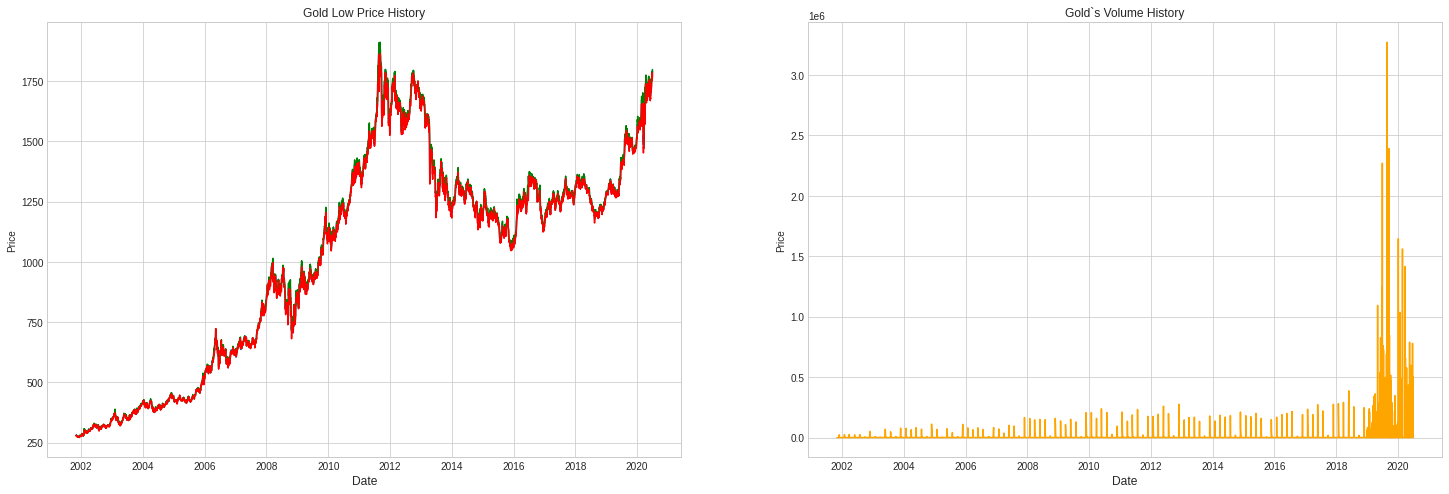

In [ ]:
# Plot the Gold Stock Price
# 1st Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
ax1.plot(gold_df["Date"], gold_df["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Price")
ax1.set_title("Gold Close Price History")

# 2nd Subplot
ax1.plot(gold_df["Date"], gold_df["High"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Price")
ax1.set_title("Gold High Price History")

# 3rd Subplot
ax1.plot(gold_df["Date"], gold_df["Low"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Price")
ax1.set_title("Gold Low Price History")

# 4th Subplot
ax2.plot(gold_df["Date"], gold_df["Volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Price")
ax2.set_title("Gold`s Volume History")
plt.show()

In [ ]:
m = Prophet()

# Lets drop the columns and focus on close
ph_df = gold_df.drop(['Open', 'High', 'Low','Volume', 'Ticks'], axis=1)
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
ph_df.drop(['Adj Close'], axis='columns', inplace=True)
ph_df.head()

ds           y
0 2001-11-01  279.700012
1 2001-11-02  279.799988
2 2001-11-05  278.500000
3 2001-11-06  279.700012
4 2001-11-07  281.000000

In [ ]:
# lets fit the data as per this algo

m = Prophet()

m.fit(ph_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Future dates will be created (for prediction - we go 1 year forward)
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices for one year forward
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
5088 2021-06-27  1652.819342  1542.990806  1775.985166
5089 2021-06-28  1644.710249  1531.500741  1767.933108
5090 2021-06-29  1644.242075  1533.205178  1767.600122
5091 2021-06-30  1644.049163  1525.060032  1759.843060
5092 2021-07-01  1642.723071  1520.876104  1763.300321

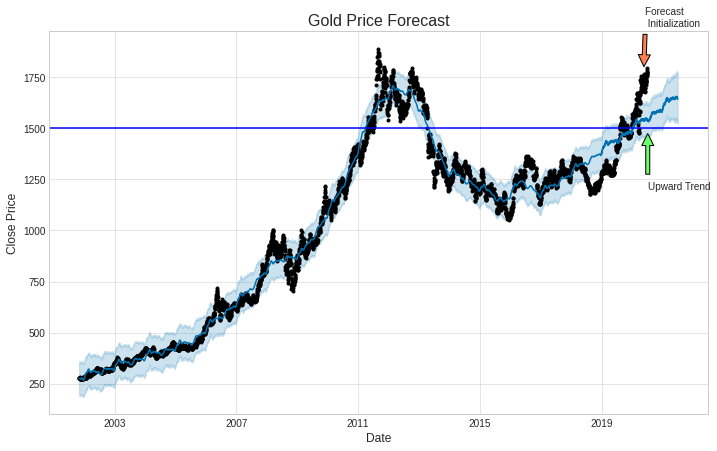

In [ ]:
import matplotlib.dates as mdates

# Lets assign the dates
starting_date = dt.datetime(2020, 6, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2020, 7, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2020, 5, 20)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Plot the Gold forecast
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Gold Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# Forecast start arrow (orange) - what triggers the forecast trend
ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 1780), xytext=(starting_date1,2000),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# Trend arrow (green)
ax1.annotate('Upward Trend', xy=(trend_date1, 1500), xytext=(trend_date1,1200),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

ax1.axhline(y=1500, color='b', linestyle='-')

plt.show()

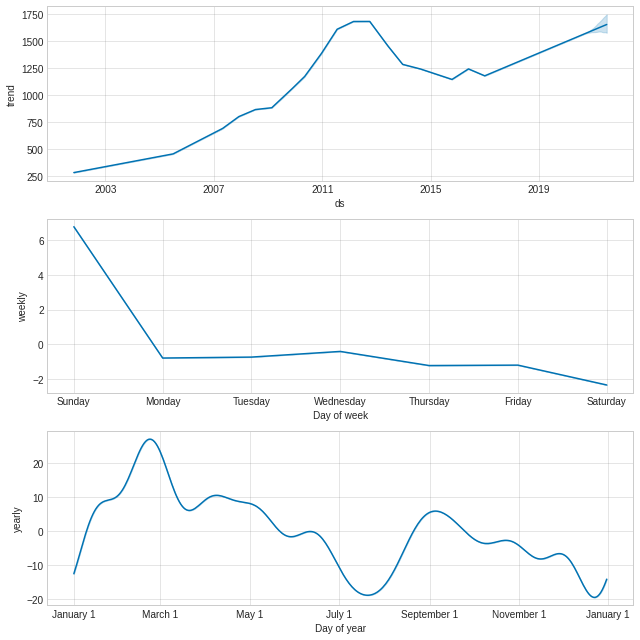

In [ ]:
# Lets see the seasonality by months and days of the week
fig2 = m.plot_components(forecast)
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


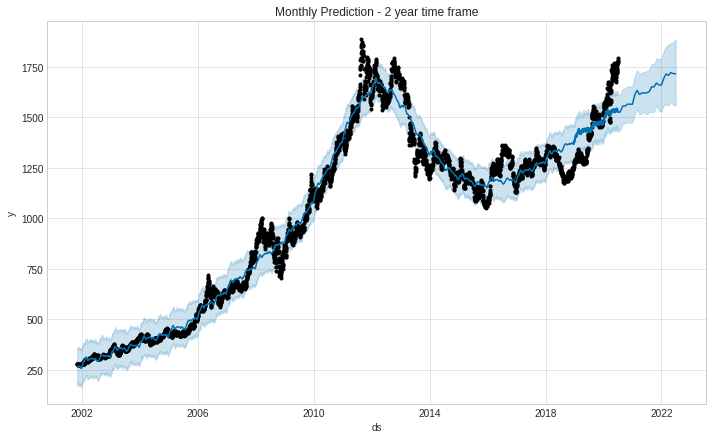

In [ ]:
# Lets take a look at the Monthly Data Predictions (24 months ahead)
m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=24, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Monthly Prediction - 2 year time frame")
plt.show()

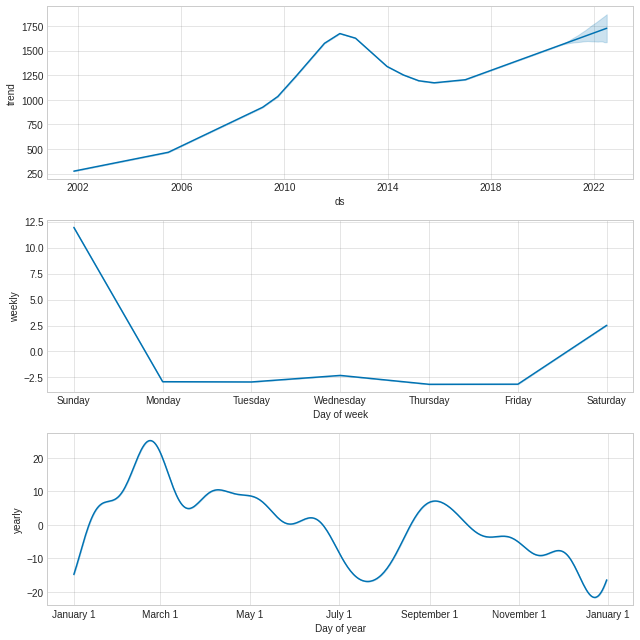

In [ ]:
# Post prediction seasonality by month and day of the week
fig = m.plot_components(fcst)
plt.show()

**PART 10: Communications and Alert System**

Email Notification

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.utils import formataddr

# This part is e-mail sending function
my_sender = '******'  # sender account
my_pass = '*****'  # sender password
# who is gonna recieve the email/s 
# add your email address here if you wanna try
my_user =['****','*****','****','****','*****']

def mail(content):
    ret = True
    try:
        for i in my_user:
            msg = MIMEText('Hi \n{}.\n Price Checker'.format(content), 'plain',
                           'utf-8')  # This is the content we wanna send
            msg['From'] = formataddr(["Gold Price Checker", my_sender])  # sender's name, sender's address
            msg['To'] = formataddr(["Dear User", i])  # reciever's name, reciever's email address
            msg['Subject'] = "This is The Price You Want"  # email's subject
            server = smtplib.SMTP_SSL("smtp.gmail.com", 465)  # sender's SMTP server，port 465
            server.login(my_sender, my_pass)  # sender's address and password
            server.sendmail(my_sender, i, msg.as_string())  # sender's address, reciever's address, send email
            server.quit()  # disconnect
            # For every e-mail successful send out 
            print("Success to send the email!")
    except Exception:  # if try would not run，then run ret=False
        ret = False
        print("Fail to send the email!")
    return ret
# Testing code
# mail("HI")

Teleghram Notification

In [ ]:
import requests
import json

# This part is data get and praparation for bot

# Gold Price in RMB, in real time 
response = requests.get("http://web.juhe.cn:8080/finance/gold/shgold?key=b83f0ee6c27c3c980cdca34dd76f8bcc", params=1)
# get the data
# the 'result' here is a dictionary 
def get(result):   
    res = result["result"][0]
    return res

# Select desired data
def which_price(res, txt):
    for i in res:
        if res[i]["variety"] == txt:
            return res[i]

# And then we take it
def take_this(dict):
    every_res = ""
    for i in dict:
        every_res += (i + "：" + str(dict[i]) + "\n")
    return every_res

The following is the raw data we get:


{
	"resultcode":"200",
	"reason":"SUCCESSED!",
	"result":[
		{
			"1":{
				"variety":"Au100g",
				"latestpri":"381.00",
				"openpri":"382.81",
				"maxpri":"383.43",
				"minpri":"380.87",
				"limit":"-0.41%",
				"yespri":"382.55",
				"totalvol":"80.00",
				"time":"2020-12-04 23:59:30"
			},
			"2":{
				"variety":"Au(T+N1)",
				"latestpri":"385.00",
				"openpri":"386.85",
				"maxpri":"388.10",
				"minpri":"385.00",
				"limit":"-0.80%",
				"yespri":"388.10",
				"totalvol":"34.00",
				"time":"2020-12-04 23:55:34"
			},
			"3":{
				"variety":"Au(T+D)",
				"latestpri":"379.84",
				"openpri":"381.55",
				"maxpri":"382.80",
				"minpri":"379.30",
				"limit":"-0.53%",
				"yespri":"381.88",
				"totalvol":"12834.00",
				"time":"2020-12-04 23:59:39"
			},
			"4":{
				"variety":"Au99.99",
				"latestpri":"380.80",
				"openpri":"383.39",
				"maxpri":"383.39",
				"minpri":"380.50",
				"limit":"-0.67%",
				"yespri":"383.38",
				"totalvol":"8701.00",
				"time":"2020-12-04 23:58:34"
			},
			"5":{
				"variety":"Au99.95",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"383.00",
				"minpri":"381.52",
				"limit":"--",
				"yespri":"381.91",
				"totalvol":"--",
				"time":"2020-12-04 23:41:22"
			},
			"6":{
				"variety":"Au50g",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"--",
				"minpri":"--",
				"limit":"--",
				"yespri":"255.00",
				"totalvol":"--",
				"time":"2020-12-04 19:50:03"
			},
			"7":{
				"variety":"Ag99.99",
				"latestpri":"--",
				"openpri":"5013.00",
				"maxpri":"5013.00",
				"minpri":"5013.00",
				"limit":"--",
				"yespri":"5013.00",
				"totalvol":"--",
				"time":"2020-12-04 19:50:06"
			},
			"8":{
				"variety":"Ag(T+D)",
				"latestpri":"4968.00",
				"openpri":"5010.00",
				"maxpri":"5049.00",
				"minpri":"4945.00",
				"limit":"-0.90%",
				"yespri":"5013.00",
				"totalvol":"9869860.00",
				"time":"2020-12-04 23:59:40"
			},
			"9":{
				"variety":"Au(T+N2)",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"380.00",
				"minpri":"380.00",
				"limit":"--",
				"yespri":"380.00",
				"totalvol":"--",
				"time":"2020-12-04 23:44:44"
			},
			"10":{
				"variety":"Pt99.95",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"228.11",
				"minpri":"225.83",
				"limit":"--",
				"yespri":"227.02",
				"totalvol":"--",
				"time":"2020-12-04 23:59:40"
			},
			"11":{
				"variety":"AU995",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"--",
				"minpri":"--",
				"limit":"--",
				"yespri":"338.00",
				"totalvol":"--",
				"time":"2020-12-04 19:50:03"
			},
			"12":{
				"variety":"AU99.99",
				"latestpri":"380.80",
				"openpri":"383.39",
				"maxpri":"383.39",
				"minpri":"380.50",
				"limit":"-0.67%",
				"yespri":"383.38",
				"totalvol":"87016.00",
				"time":"2020-12-04 23:58:32"
			},
			"13":{
				"variety":"MAUTD",
				"latestpri":"38011.00",
				"openpri":"38211.00",
				"maxpri":"38300.00",
				"minpri":"379.63",
				"limit":"9840.12%",
				"yespri":"382.40",
				"totalvol":"27218.00",
				"time":"2020-12-04 23:59:40"
			},
			"14":{
				"variety":"IAU99.99",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"--",
				"minpri":"--",
				"limit":"--",
				"yespri":"374.24",
				"totalvol":"--",
				"time":"2020-12-04 23:39:42"
			},
			"15":{
				"variety":"IAU100G",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"--",
				"minpri":"--",
				"limit":"--",
				"yespri":"396.90",
				"totalvol":"--",
				"time":"2020-12-04 22:55:37"
			},
			"16":{
				"variety":"IAU99.5",
				"latestpri":"--",
				"openpri":"--",
				"maxpri":"--",
				"minpri":"--",
				"limit":"--",
				"yespri":"237.80",
				"totalvol":"--",
				"time":"2020-12-04 19:50:03"
			}
		}
	],
	"error_code":0
}

In [ ]:
!pip install telepot
import time
import telepot
import sys
from telepot.loop import MessageLoop
from telepot.namedtuple import ReplyKeyboardMarkup
from telepot.namedtuple import InlineKeyboardMarkup, InlineKeyboardButton
from telepot.delegate import pave_event_space, per_chat_id, create_open
# Bot code here 
class PriceChecker(telepot.helper.ChatHandler):
# The majority function for this bot is check the real gold price in RMB


    def __init__(self, *args, **kwargs):
        super(PriceChecker, self).__init__(*args, **kwargs)
        # give a indicator so bot knows where it is
        self.indicator = "price_check"
        # what it wanna send in the email
        self.wannasend = {}

    def on_chat_message(self, msg):
        content_type, chat_type, chat_id = telepot.glance(msg)
        print(content_type, chat_type, chat_id)
        # add the checking list, randomly select some, the most common use one is "AU99.99"
        p_list = [["AU99.99"], ["Au100g"], ["Au(T+N1"], ["Au(T+D)"], ["Au(T+N1)"],['MAUTD']]
        if self.indicator == "price_check":
          # for now this bot can check the price only
            if msg["text"] == "/price":
                mark_up = ReplyKeyboardMarkup(keyboard=p_list, one_time_keyboard=True)
                # To 
                bot.sendMessage(chat_id, text="What price you want to check?", reply_markup=mark_up)
              # reply the price of selected product
            elif [msg["text"]] in p_list:
              # Using the function in last chunk
                data = get(response.json())
                say0 = which_price(data, msg["text"])
                say = take_this(say0)
                # storage what we may send via email
                self.wannasend["say"] = say
                bot.sendMessage(chat_id, say)
                self.indicator = "e-mail check"
            # Send an email
        if self.indicator == "e-mail check":
            mark_up = ReplyKeyboardMarkup(keyboard=[["Yes"], ["No"]], one_time_keyboard=True)
            bot.sendMessage(chat_id, text="Do you want to share with your friends via email?", reply_markup=mark_up)
            self.indicator = "e-mail check_2"
        if self.indicator == "e-mail check_2":
            if msg["text"] == "Yes":
                mail(self.wannasend["say"])
                bot.sendMessage(chat_id, "Done! Have a good day!")
                # The indicator reset to the price_check stage
                self.indicator = "price_check"
            elif msg["text"] == "No":
                bot.sendMessage(chat_id, "Ok, have a good day!")
                # The indicator reset to the price_check stage
                self.indicator = "price_check"
 # Considering we are using reply keyboard here, we cancel the "bug!" reply
 #       elif content_type == 'text':
   #         bot.sendMessage(chat_id, "bug!")
      #      self.indicator = "price_check"


# token
# 
# 
TOKEN = '*****************'

### bot = telepot.DelegatorBot(TOKEN,
                          [pave_event_space()(
                               per_chat_id(), create_open, PriceChecker, timeout=100000
                           ), ])
# run the bot


### #MessageLoop(bot).run_as_thread()
# So we know this bot is running #
### print('Running ...')

# Keep the program running.
# If you dont stop it it will run
# while 1:
  #time.sleep(10)

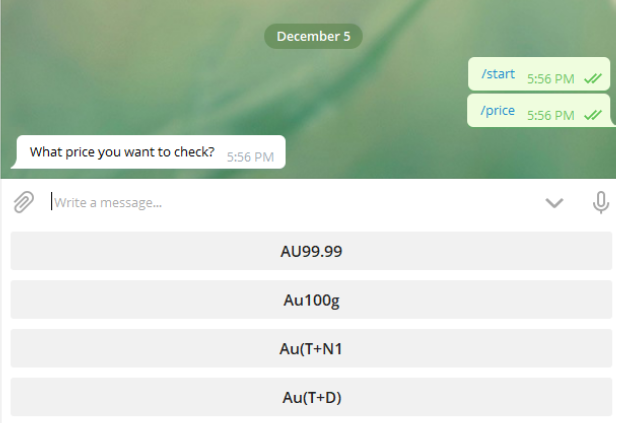

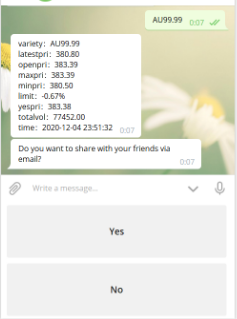

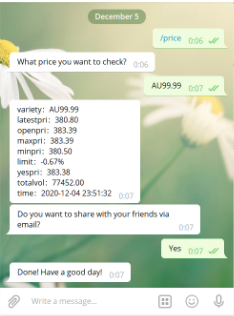